In [ ]:
!gdown 1Bsro4zJRZeycEuPEZ7iv7bSCKM7Nnhtw
!unzip -q *.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Bsro4zJRZeycEuPEZ7iv7bSCKM7Nnhtw
From (redirected): https://drive.google.com/uc?id=1Bsro4zJRZeycEuPEZ7iv7bSCKM7Nnhtw&confirm=t&uuid=0061ce2d-533a-4fb9-94b7-d816e2be58ef
To: /content/cvc-clinicdb.zip
100% 137M/137M [00:02<00:00, 48.9MB/s]


In [ ]:
import os
import cv2
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import regionprops, label


# Thống kê cơ bản cho dữ liệu

In [ ]:
# Đường dẫn gốc
dataset_dir = "/content/PNG"
images_dir = os.path.join(dataset_dir, "Original")
masks_dir = os.path.join(dataset_dir, "Ground Truth")

# Lấy danh sách file ảnh
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

print("Số lượng ảnh:", len(image_files))
print("Số lượng mask:", len(mask_files))


Số lượng ảnh: 612
Số lượng mask: 612


Kích thước trung bình: 384.0 x 288.0
Min size: 384x288, Max size: 384x288


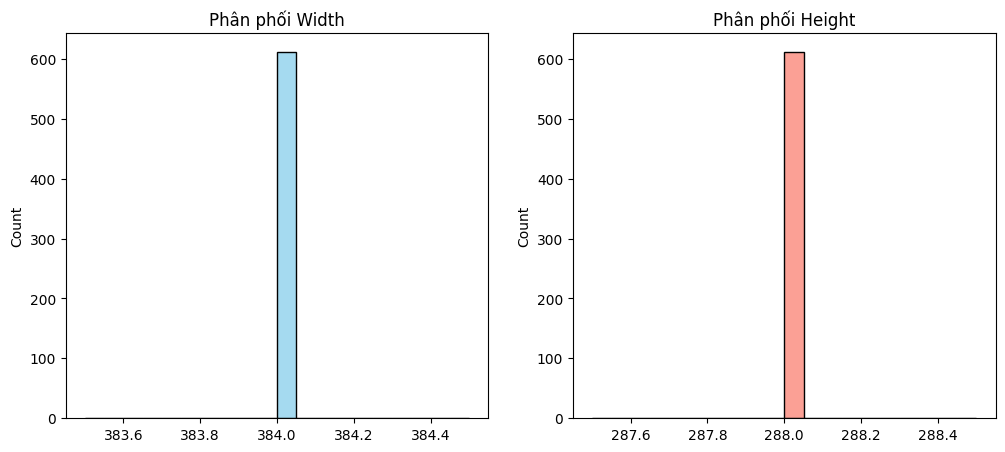

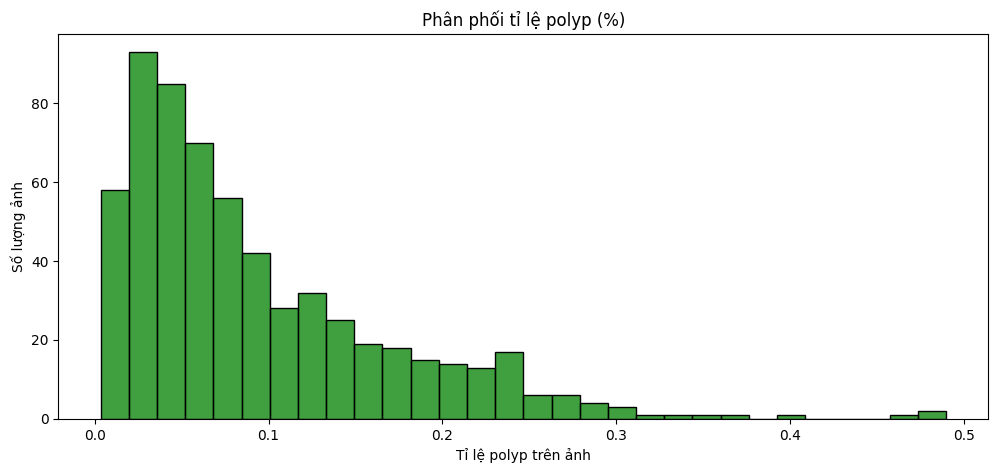

Trung bình tỉ lệ polyp: 9.30%


In [ ]:
img_shapes = []
polyp_ratios = []

for img_name, mask_name in zip(image_files, mask_files):
    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"Lỗi đọc file: {img_name}, {mask_name}")
        continue

    h, w = img.shape[:2]
    img_shapes.append((h, w))

    polyp_ratio = np.sum(mask > 0) / (h * w)
    polyp_ratios.append(polyp_ratio)

# Thống kê kích thước ảnh
heights, widths = zip(*img_shapes)
print(f"Kích thước trung bình: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Min size: {min(widths)}x{min(heights)}, Max size: {max(widths)}x{max(heights)}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=False, bins=20, color="skyblue")
plt.title("Phân phối Width")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=False, bins=20, color="salmon")
plt.title("Phân phối Height")
plt.show()

# Phân phối tỉ lệ polyp
plt.figure(figsize=(12, 5))
sns.histplot(polyp_ratios, bins=30, color="green")
plt.xlabel("Tỉ lệ polyp trên ảnh")
plt.ylabel("Số lượng ảnh")
plt.title("Phân phối tỉ lệ polyp (%)")
plt.show()

print(f"Trung bình tỉ lệ polyp: {np.mean(polyp_ratios)*100:.2f}%")

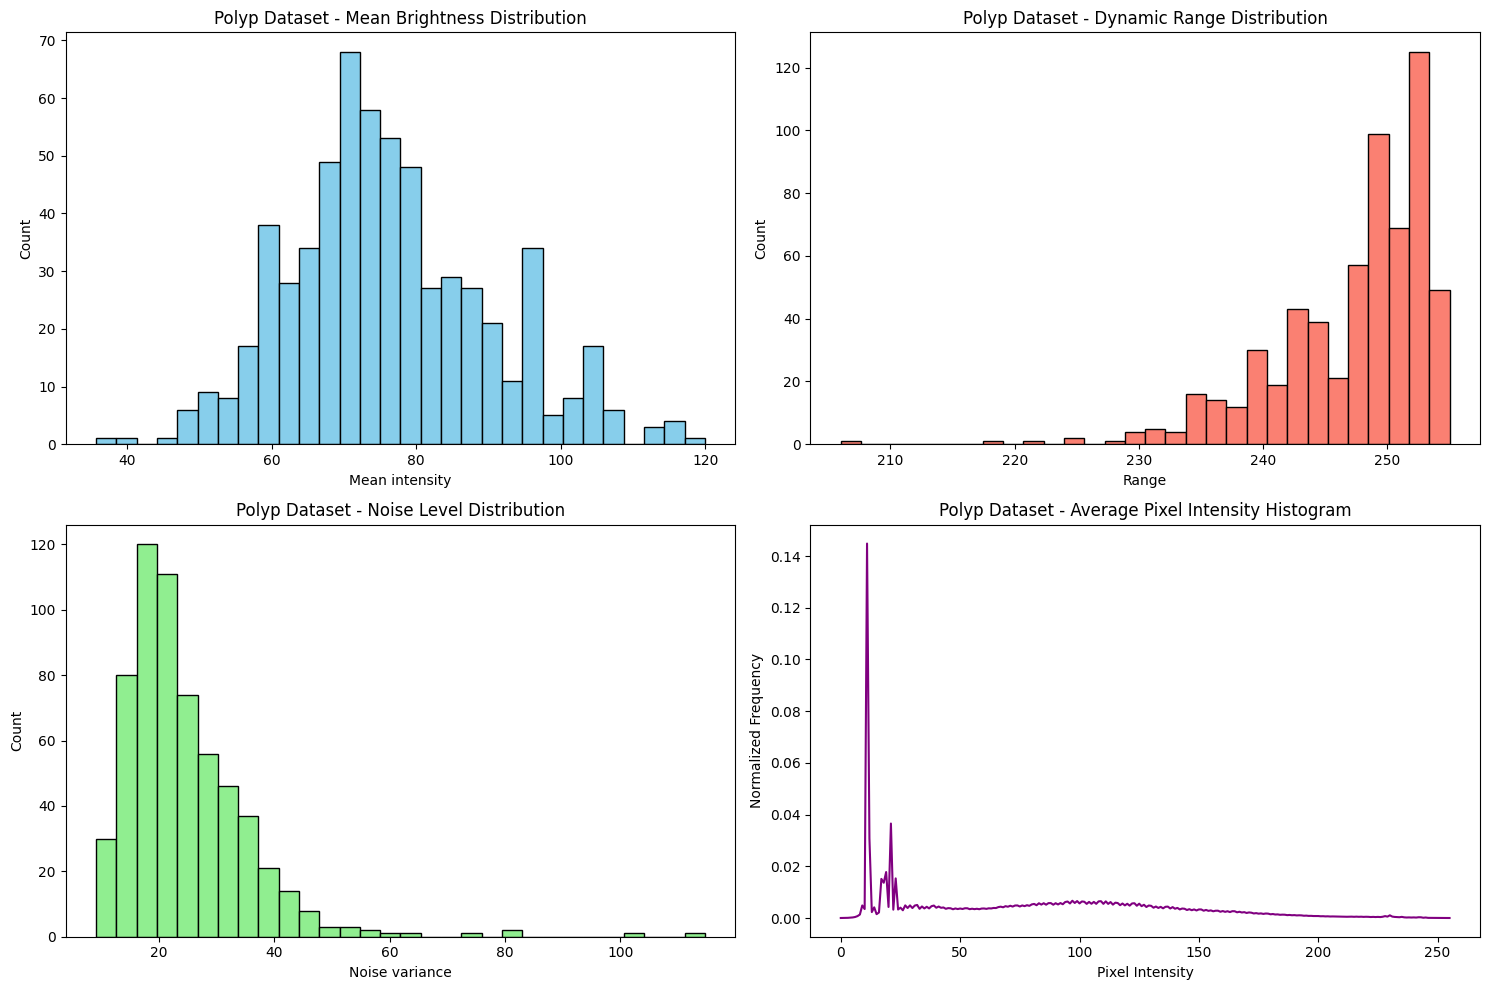

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_image_stats(images_dir, sample_size=None):
    image_files = sorted(os.listdir(images_dir))
    if sample_size:
        image_files = image_files[:sample_size]

    means, stds, dynamic_ranges, noises = [], [], [], []
    hist_list = []

    for f in image_files:
        img = cv2.imread(os.path.join(images_dir, f))
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Mean + Std
        mean_val = np.mean(gray)
        std_val = np.std(gray)
        means.append(mean_val)
        stds.append(std_val)

        # Dynamic range
        dynamic_range = gray.max() - gray.min()
        dynamic_ranges.append(dynamic_range)

        # Noise (variance sau Gaussian blur)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        noise = np.var(gray.astype("float32") - blur.astype("float32"))
        noises.append(noise)

        # Histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        hist_list.append(hist.flatten())

    return {
        "means": np.array(means),
        "stds": np.array(stds),
        "dynamic_ranges": np.array(dynamic_ranges),
        "noises": np.array(noises),
        "hists": np.array(hist_list)
    }


def plot_dataset_stats(stats, dataset_name="Dataset"):
    plt.figure(figsize=(15, 10))

    # Mean brightness
    plt.subplot(2, 2, 1)
    plt.hist(stats["means"], bins=30, color="skyblue", edgecolor="black")
    plt.title(f"{dataset_name} - Mean Brightness Distribution")
    plt.xlabel("Mean intensity")
    plt.ylabel("Count")

    # Dynamic range
    plt.subplot(2, 2, 2)
    plt.hist(stats["dynamic_ranges"], bins=30, color="salmon", edgecolor="black")
    plt.title(f"{dataset_name} - Dynamic Range Distribution")
    plt.xlabel("Range")
    plt.ylabel("Count")

    # Noise level
    plt.subplot(2, 2, 3)
    plt.hist(stats["noises"], bins=30, color="lightgreen", edgecolor="black")
    plt.title(f"{dataset_name} - Noise Level Distribution")
    plt.xlabel("Noise variance")
    plt.ylabel("Count")

    # Average histogram
    plt.subplot(2, 2, 4)
    mean_hist = stats["hists"].mean(axis=0)
    plt.plot(mean_hist, color="purple")
    plt.title(f"{dataset_name} - Average Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")

    plt.tight_layout()
    plt.show()


# Example usage
stats = compute_image_stats(images_dir, sample_size=1000)
plot_dataset_stats(stats, "Polyp Dataset")


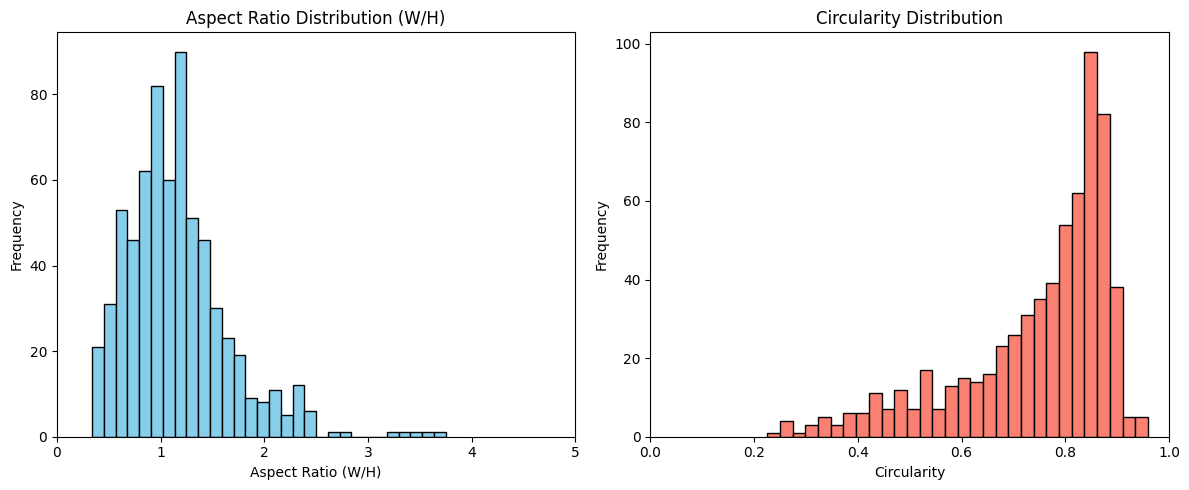

In [ ]:
def compute_shape_descriptors(masks_dir, max_aspect=10.0):
    mask_files = sorted(os.listdir(masks_dir))
    aspect_ratios, circularities = [], []

    for f in mask_files:
        mask = cv2.imread(os.path.join(masks_dir, f), cv2.IMREAD_GRAYSCALE)
        if mask is None or np.sum(mask) == 0:
            continue

        labeled = label(mask > 0)
        for region in regionprops(labeled):
            minr, minc, maxr, maxc = region.bbox
            h, w = maxr - minr, maxc - minc
            if h > 0:
                ar = w / h
                if ar <= max_aspect:   # lọc outlier
                    aspect_ratios.append(ar)

            perimeter = region.perimeter
            area = region.area
            if perimeter > 0:
                circ = 4 * np.pi * area / (perimeter ** 2)
                if circ <= 1.0:       # lọc để đúng logic
                    circularities.append(circ)

    return aspect_ratios, circularities

def plot_shape_descriptors(aspect_ratios, circularities):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(aspect_ratios, bins=30, color='skyblue', edgecolor='black')
    plt.title("Aspect Ratio Distribution (W/H)")
    plt.xlabel("Aspect Ratio (W/H)")
    plt.ylabel("Frequency")
    plt.xlim(0, 5)   # hầu hết polyp sẽ ở 0–5

    plt.subplot(1, 2, 2)
    plt.hist(circularities, bins=30, color='salmon', edgecolor='black')
    plt.title("Circularity Distribution")
    plt.xlabel("Circularity")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)   # circularity đúng logic nằm trong [0,1]

    plt.tight_layout()
    plt.show()

# Chạy
aspect_ratios, circularities = compute_shape_descriptors(masks_dir)
plot_shape_descriptors(aspect_ratios, circularities)

Aspect Ratio Distribution (W/H): Biểu đồ này mô tả phân bố tỷ lệ giữa chiều rộng và chiều cao của polyp.

*   Giá trị ~1: polyp có hình dạng gần vuông hoặc tròn.
*   Giá trị >1: polyp có xu hướng dẹt theo chiều ngang.
*   Giá trị <1: polyp dẹt theo chiều dọc.
*   Phần lớn các polyp trong tập dữ liệu có aspect ratio nằm gần 1, cho thấy hình dạng khá cân đối.

Circularity Distribution: Biểu đồ này cho thấy mức độ tròn của polyp, được tính dựa trên diện tích và chu vi.


*   Circularity ≈ 1: polyp tròn đều, biên mượt.
*   Circularity thấp (gần 0): polyp có hình dạng méo mó, biên phức tạp.
*   Đa số polyp trong tập dữ liệu có circularity ở mức trung bình, chỉ một số ít có giá trị gần 1.

In [ ]:
def check_mask_consistency(masks_dir):
    mask_files = sorted(os.listdir(masks_dir))
    empty_masks, noisy_masks = [], []

    for f in mask_files:
        mask = cv2.imread(os.path.join(masks_dir, f), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        if np.sum(mask) == 0:
            empty_masks.append(f)

        edges = cv2.Canny(mask, 100, 200)
        edge_density = np.sum(edges > 0) / mask.size
        if edge_density > 0.1:  # nhiều biên nhỏ có thể là noise
            noisy_masks.append(f)

    print(f"Số mask rỗng: {len(empty_masks)}")
    print(f"Số mask nghi ngờ noise: {len(noisy_masks)}")
    return empty_masks, noisy_masks

# Consistency check
empty_masks, noisy_masks = check_mask_consistency(masks_dir)

Số mask rỗng: 0
Số mask nghi ngờ noise: 0


# Plot ảnh

Tổng số ảnh: 612
Tổng số mask: 612


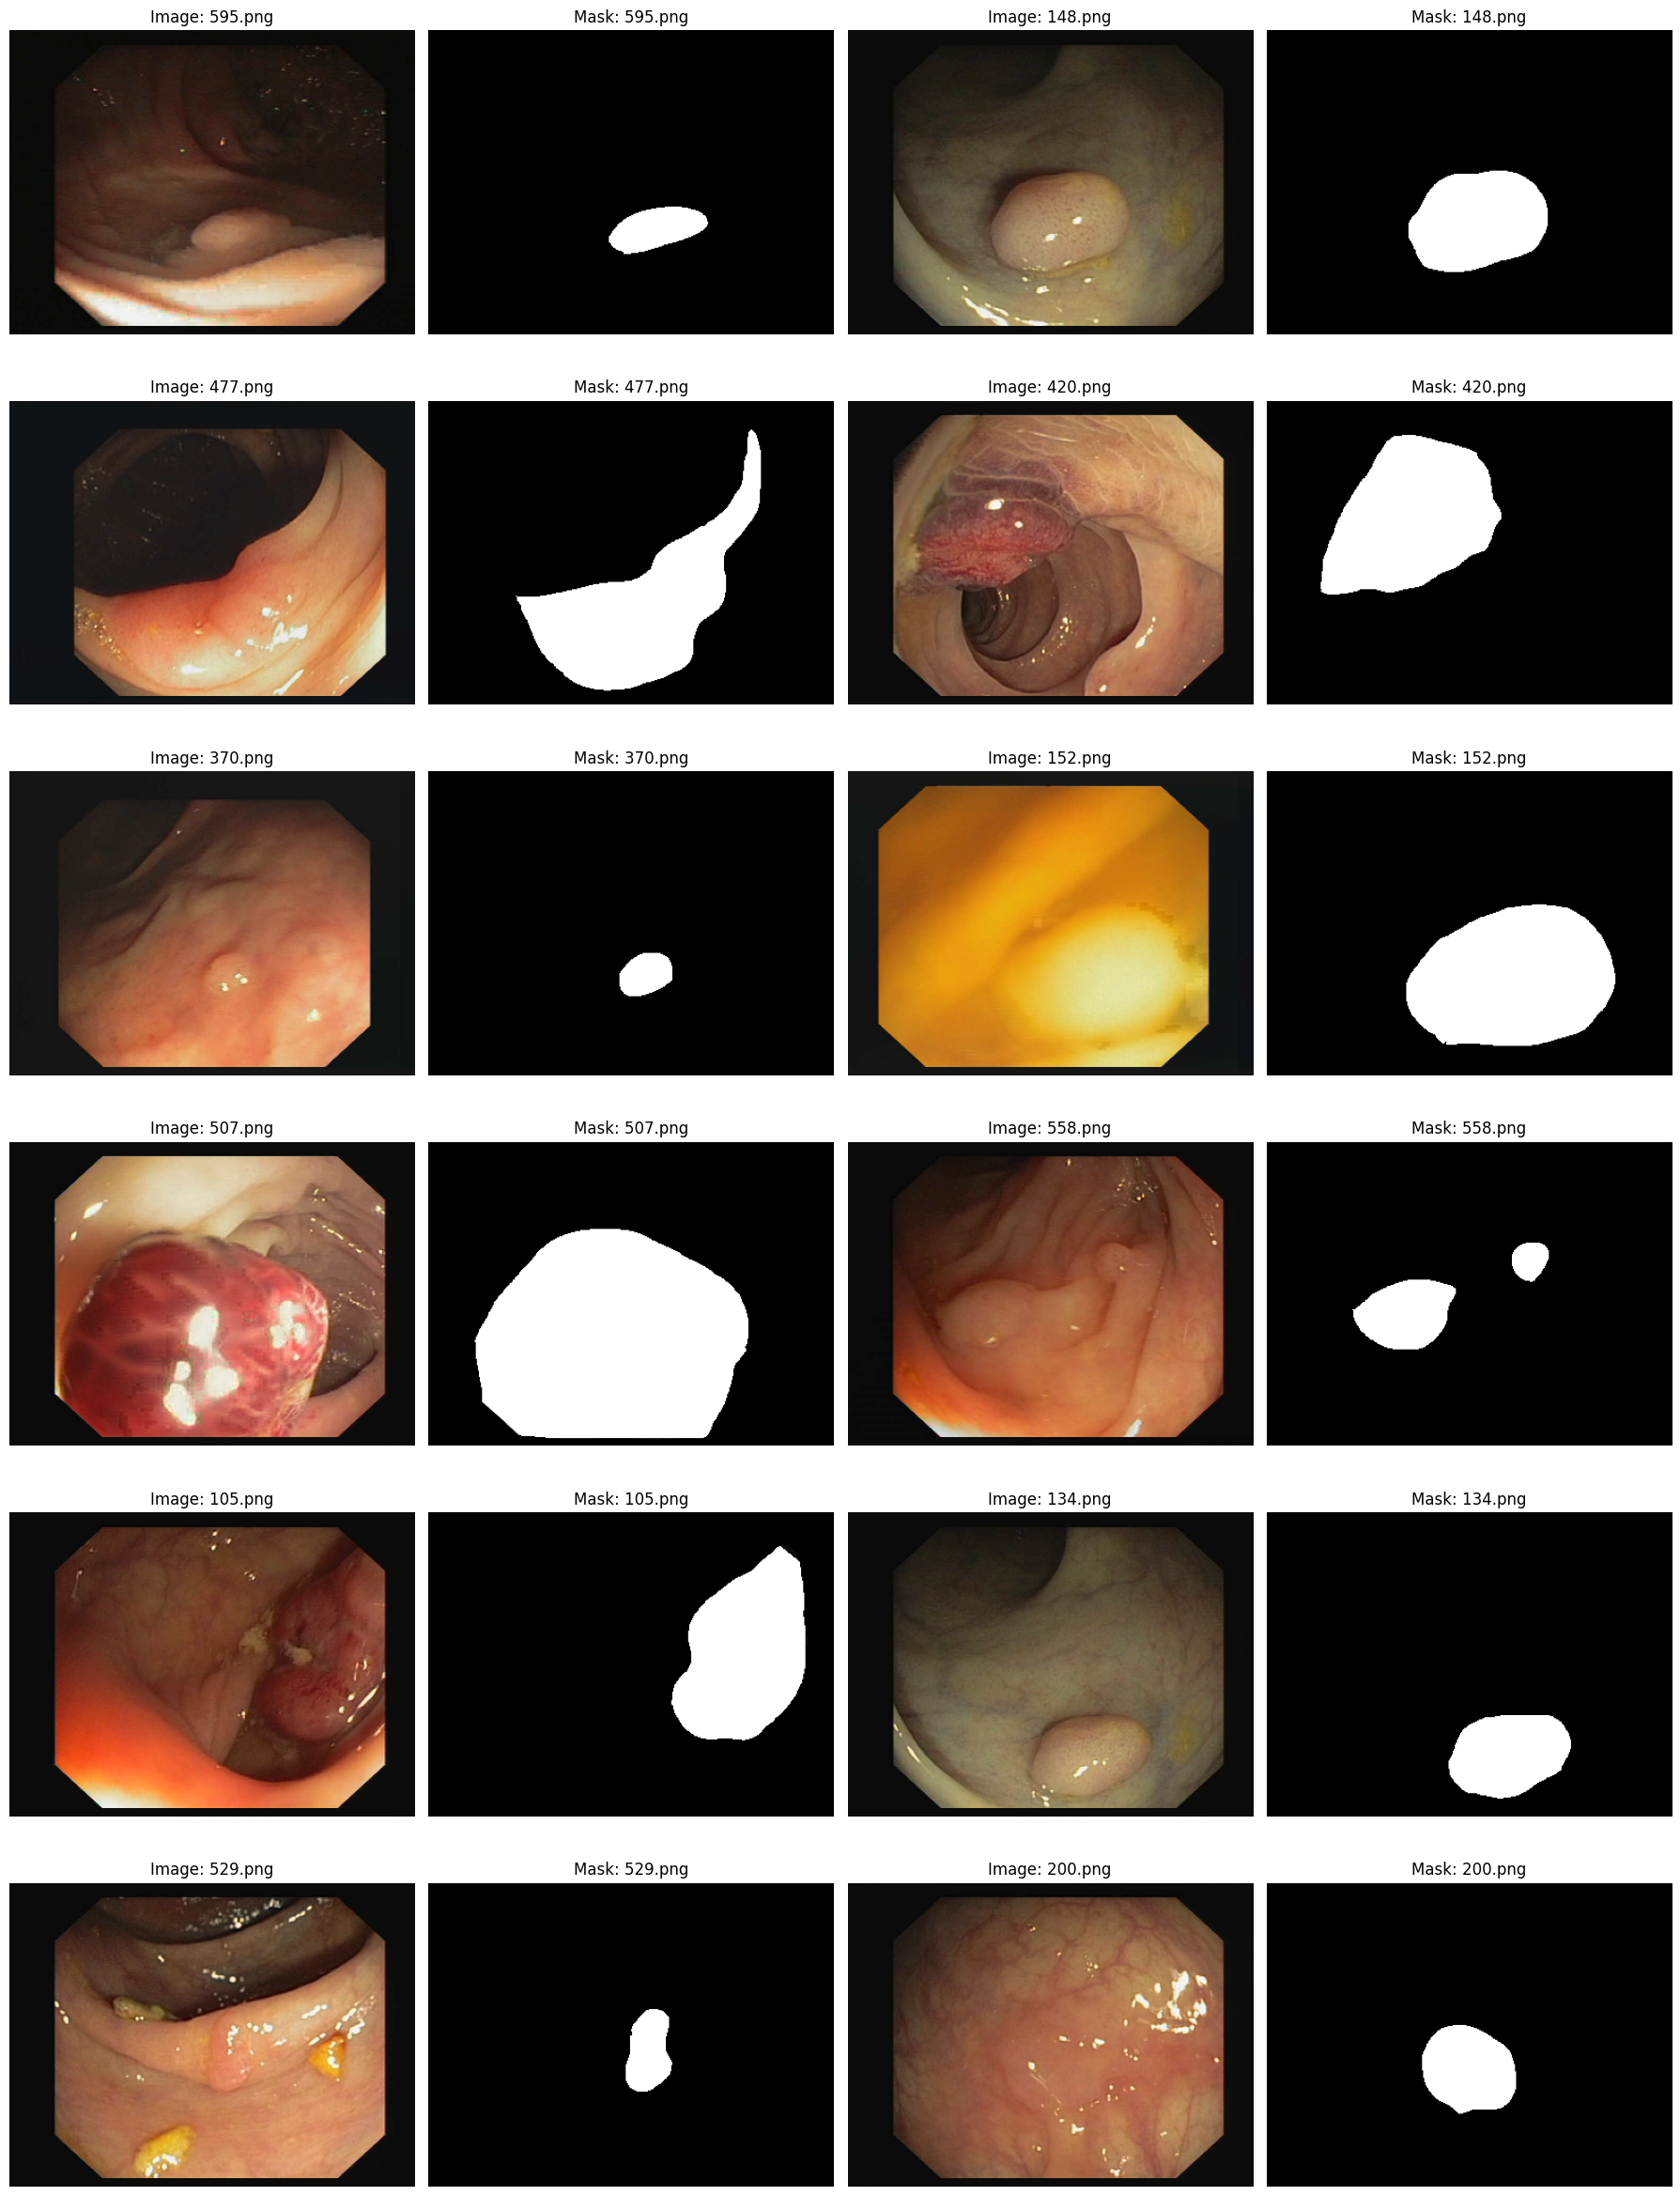

In [ ]:
def eda_segmentation_dataset(images_dir, masks_dir, sample_size=8):
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    print(f"Tổng số ảnh: {len(image_files)}")
    print(f"Tổng số mask: {len(mask_files)}")
    assert len(image_files) == len(mask_files), "Số lượng ảnh và mask không khớp!"

    # Chọn ngẫu nhiên sample_size ảnh
    sample_idx = np.random.choice(len(image_files), sample_size, replace=False)

    # Tính số hàng (mỗi hàng chứa 2 cặp ảnh-mask => 4 cột)
    n_cols = 4
    n_rows = int(np.ceil(sample_size / 2))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))

    # Nếu chỉ có 1 hàng thì axes là 1D array
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(sample_idx):
        row = i // 2
        col = (i % 2) * 2

        img = cv2.imread(os.path.join(images_dir, image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(masks_dir, mask_files[idx]), cv2.IMREAD_GRAYSCALE)

        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Image: {image_files[idx]}")
        axes[row, col].axis("off")

        axes[row, col+1].imshow(mask, cmap="gray")
        axes[row, col+1].set_title(f"Mask: {mask_files[idx]}")
        axes[row, col+1].axis("off")

    plt.tight_layout()
    plt.show()

eda_segmentation_dataset(images_dir, masks_dir, sample_size=12)

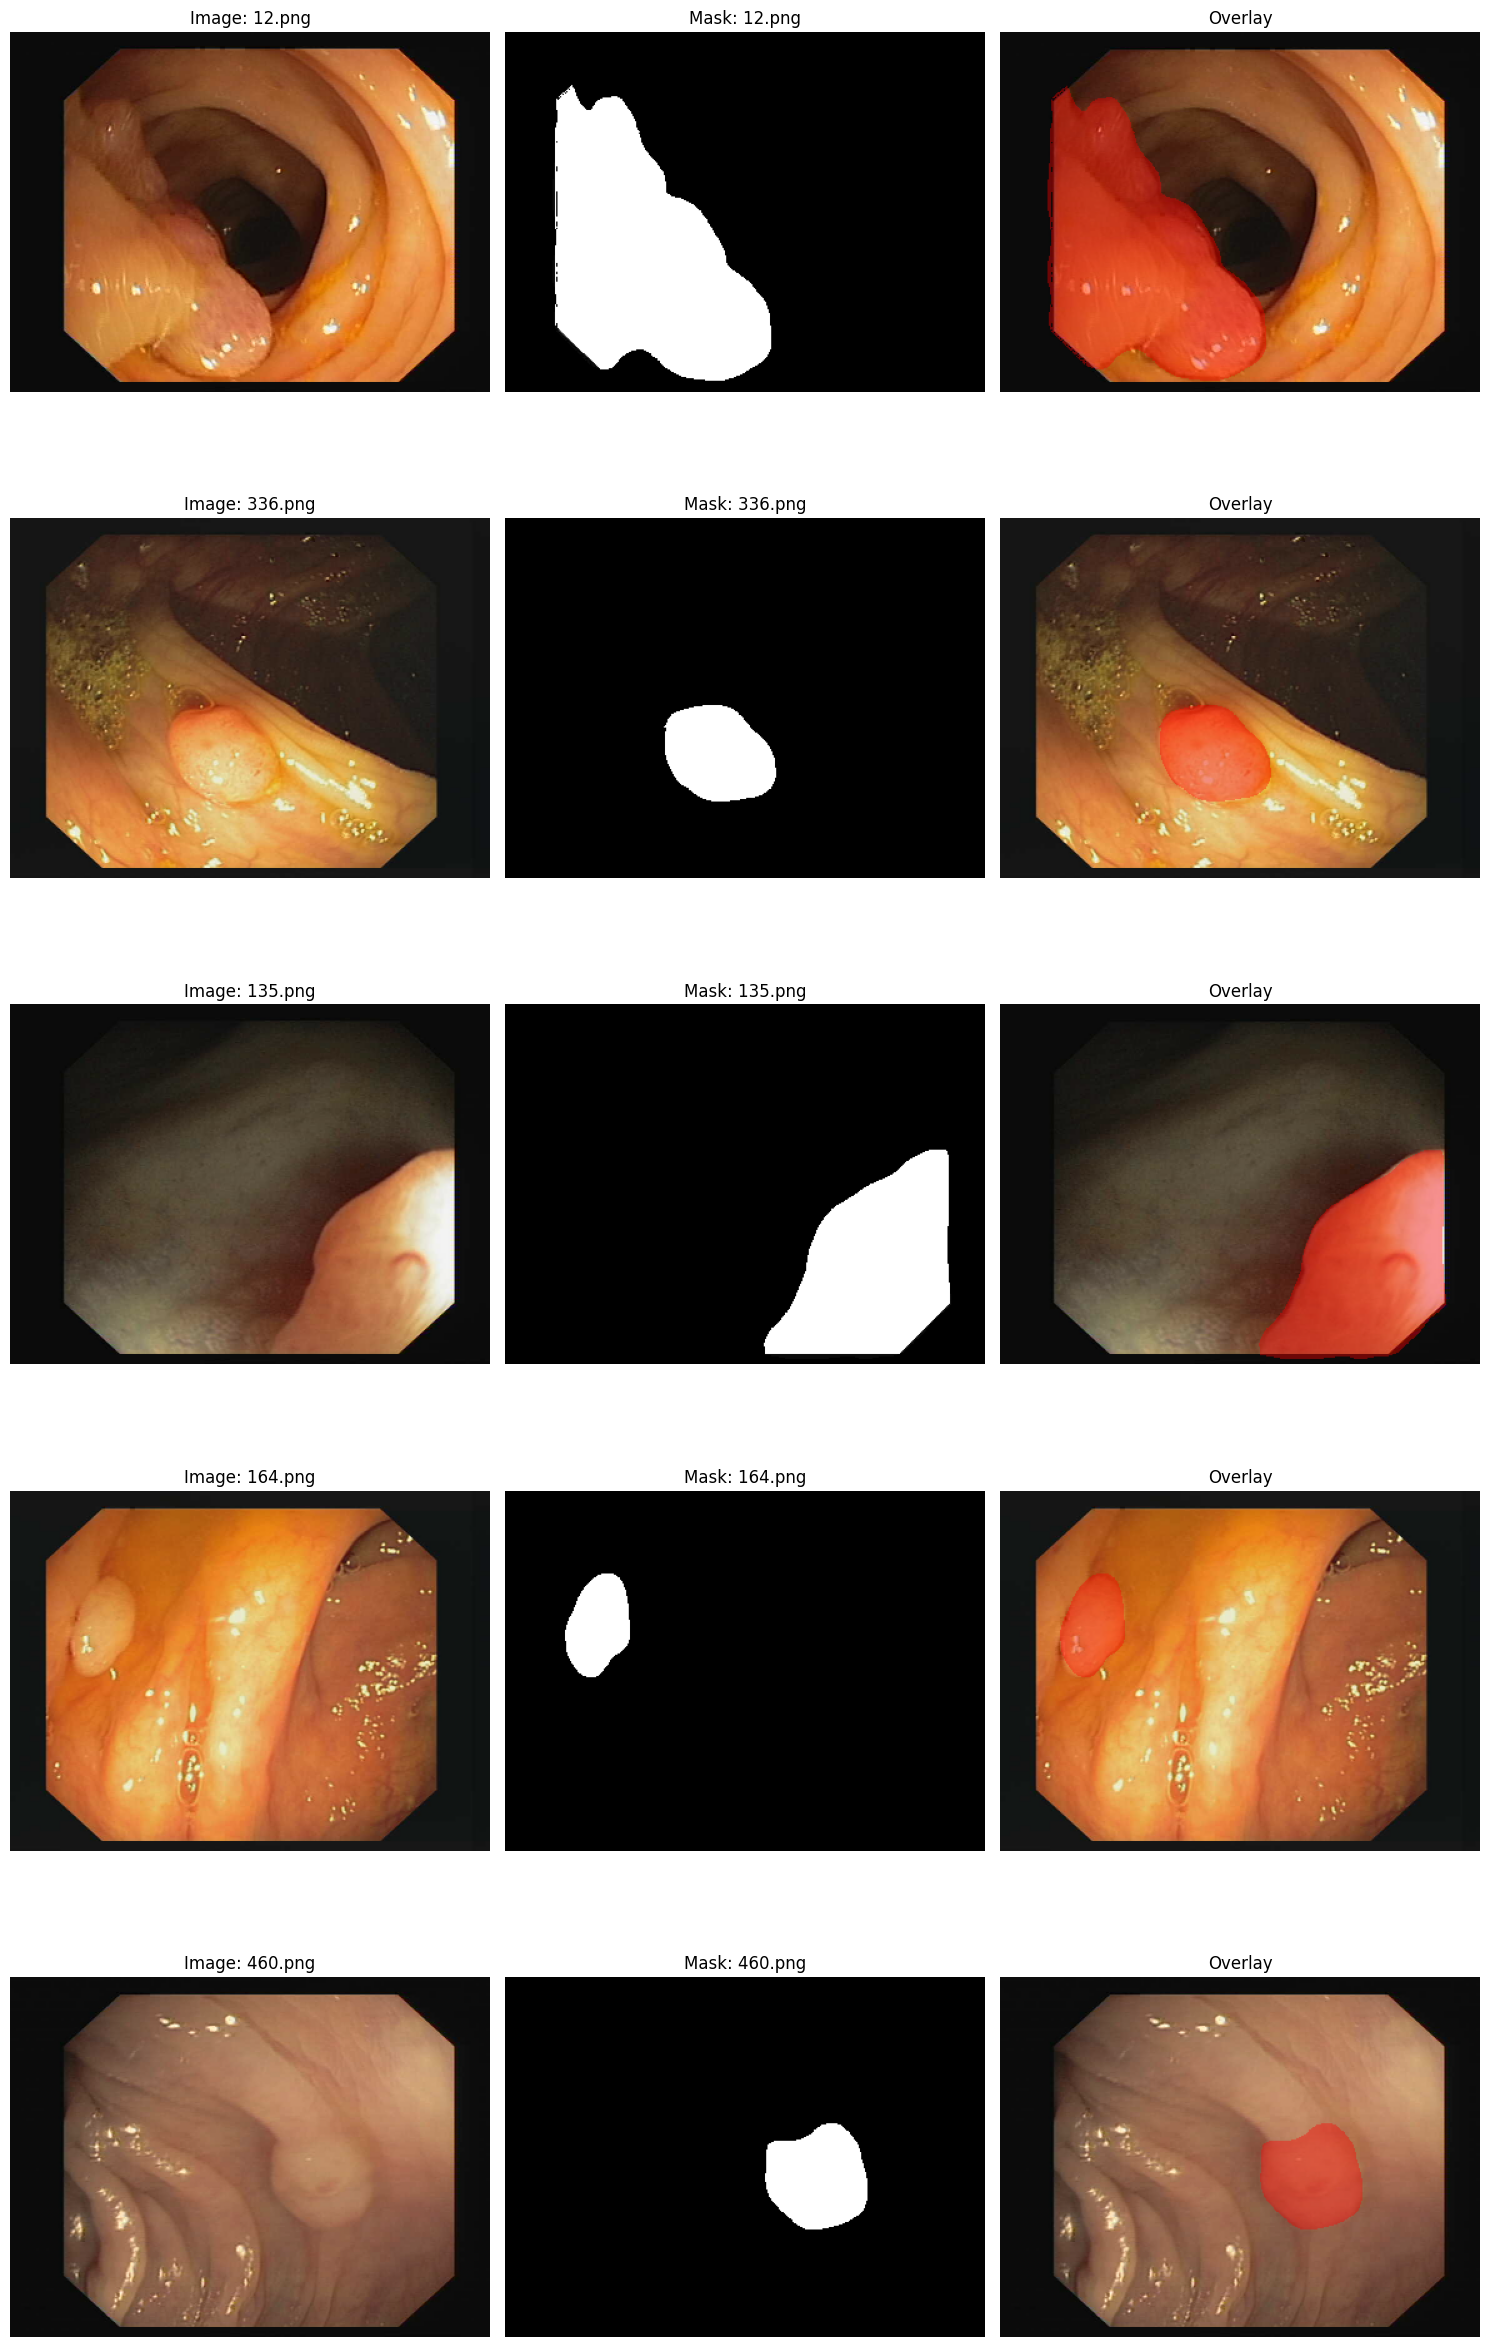

In [ ]:
def plot_images_masks_overlays(images_dir, masks_dir, sample_size=5, alpha=0.4):
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    assert len(image_files) == len(mask_files), "Số lượng ảnh và mask không khớp!"

    # Chọn ngẫu nhiên sample_size ảnh
    sample_idx = np.random.choice(len(image_files), sample_size, replace=False)

    fig, axes = plt.subplots(sample_size, 3, figsize=(15, 5*sample_size))

    # Nếu chỉ có 1 ảnh thì axes thành 1D → ép thành 2D cho đồng nhất
    if sample_size == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(sample_idx):
        img = cv2.imread(os.path.join(images_dir, image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(masks_dir, mask_files[idx]), cv2.IMREAD_GRAYSCALE)

        # Overlay: tô đỏ vùng mask
        overlay = img.copy()
        overlay[mask > 0] = (255, 0, 0)
        blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        # Cột 1: ảnh gốc
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {image_files[idx]}")
        axes[i, 0].axis("off")

        # Cột 2: mask
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {mask_files[idx]}")
        axes[i, 1].axis("off")

        # Cột 3: overlay
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

plot_images_masks_overlays(
    images_dir=images_dir,
    masks_dir=masks_dir,
    sample_size=5
)


# Load ảnh

In [ ]:
# -----------------------------
# Augmentation
# -----------------------------
def get_augmentations(img_size=256, augment=True):
    """
    Trả về Albumentations Compose cho ảnh segmentation.
    augment=True: có các phép xoay, flip, elastic, gamma
    augment=False: chỉ resize + ToTensor
    """
    if augment:
        return A.Compose([
            A.Rotate(limit=(0, 90), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ElasticTransform(
                alpha=1, sigma=50, alpha_affine=10,
                interpolation=cv2.INTER_LINEAR,
                border_mode=cv2.BORDER_REFLECT_101,
                approximate=True, same_dxdy=True, p=0.5
            ),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            A.Resize(img_size, img_size),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            ToTensorV2()
        ])


# -----------------------------
# Dataset cho Kvasir-SEG
# -----------------------------
class CVC_Clinicdb(Dataset):
    def __init__(self, images_dir, masks_dir, img_size=256, augment=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform = get_augmentations(img_size=img_size, augment=augment)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"].long()

        return image, mask


# -----------------------------
# Hàm tạo DataLoader
# -----------------------------
def get_dataloaders(dataset_class, images_dir, masks_dir,
                    img_size=256, batch_size=4,
                    split_ratio=0.8, num_workers=2):
    """
    dataset_class: class Dataset (vd: CVC_Clinicdb, CVCDataset)
    images_dir: folder chứa ảnh
    masks_dir: folder chứa mask
    """
    # dataset đầy đủ (augment=True để chia train)
    full_dataset = dataset_class(images_dir, masks_dir,
                                 img_size=img_size, augment=True)

    n_total = len(full_dataset)
    n_train = int(n_total * split_ratio)
    n_test = n_total - n_train

    train_dataset, test_dataset_idx = random_split(full_dataset, [n_train, n_test])

    # test dataset không augment → tạo lại object mới
    test_dataset = dataset_class(images_dir, masks_dir,
                                 img_size=img_size, augment=False)
    # giữ lại đúng các index test
    test_dataset.image_files = [full_dataset.image_files[i] for i in test_dataset_idx.indices]
    test_dataset.mask_files = [full_dataset.mask_files[i] for i in test_dataset_idx.indices]

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    return train_loader, test_loader


In [ ]:
# cvc-clinicdb
train_loader, test_loader = get_dataloaders(
    dataset_class=CVC_Clinicdb,
    images_dir=images_dir,
    masks_dir=masks_dir,
    img_size=256,
    batch_size=8
)

for imgs, masks in train_loader:
    print("Image batch shape:", imgs.shape)   # (B, C, H, W)
    print("Mask batch shape:", masks.shape)   # (B, H, W)
    print("Mask unique labels:", [torch.unique(m) for m in masks])
    break


/tmp/ipython-input-995767035.py:15: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(


Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Mask unique labels: [tensor([  0,   7,  10,  11,  20,  45,  47,  71,  80,  83, 116, 135, 136, 167,
        178, 180, 196, 198, 214, 217, 219, 255]), tensor([  0, 255]), tensor([  0,  11, 255]), tensor([  0,  11, 255]), tensor([  0, 255]), tensor([  0, 255]), tensor([  0, 255]), tensor([  0, 255])]
